# Finding Jacobian from time series
This script approximates the Jacobian matrix of a dynamical system for a given time series, using linear regression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.signal import savgol_filter


In [2]:
#parameters of the system
rho = 28
sigma = 10
beta = 8.0/3

#Initial condition
x0=[1,0,0]

def difeq(data,t):
    '''System of differential eqautions'''
    x,y,z=data
    xp=sigma*(y-x)
    yp=x*(rho-z)-y
    zp=x*y-beta*z
    return [xp,yp,zp]

def J_explicit(point):
    """Explicit Jacobian for Lorenz system at point tseries[j]"""
    x,y,z=point
    J=np.array([[-sigma,sigma,0],[rho-z,-1,-x],[y,x,-beta]])
    return J

In [3]:
dt=0.01
T=2000
N=int(T/dt)
discard_t = 1000
T_total = T+discard_t
t=np.arange(0,T_total,dt)
X=integrate.odeint(difeq,x0,t)[int(discard_t):]

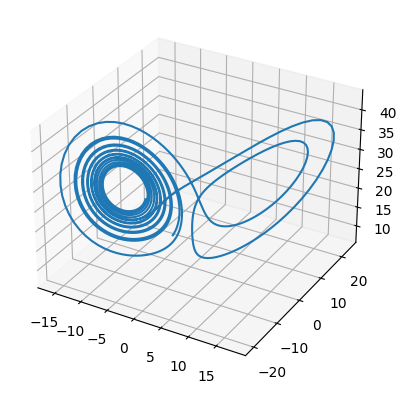

In [4]:
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
plt.plot(X[0:1200,0],X[0:1200,1],X[0:1200,2])

In [5]:
tmax=100
rmax=int(len(X)/10)
eps_r_t = np.zeros((rmax,tmax))
t0 = 200
for i in range(1,tmax):
    tp = np.linalg.norm(X[t0:-i]-X[t0+i:],axis=1)
    tp = np.sort(tp)
    eps_r_t[:,i] = tp[:rmax]        

In [6]:
def norm2one(x):
    ma=np.max(x,axis=0);
    mi=np.min(x,axis=0);
    return (x-mi)/(ma-mi)

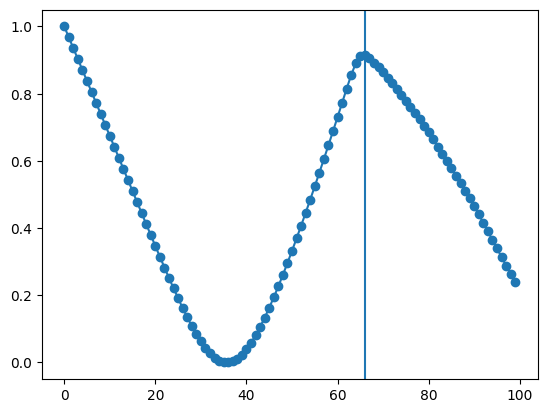

Period :  66


In [7]:
eps_t = np.mean(eps_r_t,axis=0)
peaks, _ = find_peaks(norm2one(-eps_t), prominence=.01)
plt.plot(np.arange(tmax),norm2one(-eps_t),marker='o')
plt.axvline(peaks[0])
plt.show()
print("Period : ",peaks[0])

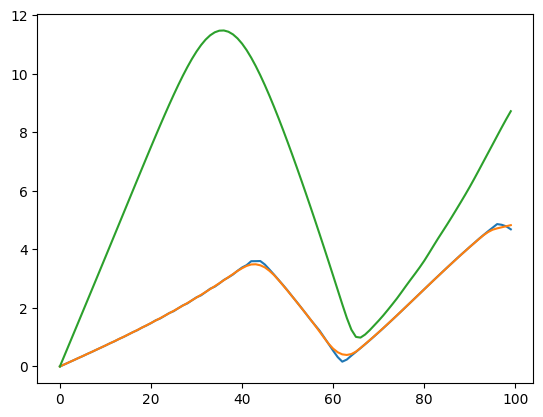

0.77958081814864


In [8]:
#the savgol filter just smooths the curve a bit
epsilon = savgol_filter(eps_r_t[8,:],15,1)[peaks[0]]#eps_r_t[9,peaks[0]]

plt.plot(eps_r_t[9,:])
plt.plot(savgol_filter(eps_r_t[9,:],7,1))
plt.plot(eps_r_t.mean(axis=0))
plt.show()

print(epsilon)

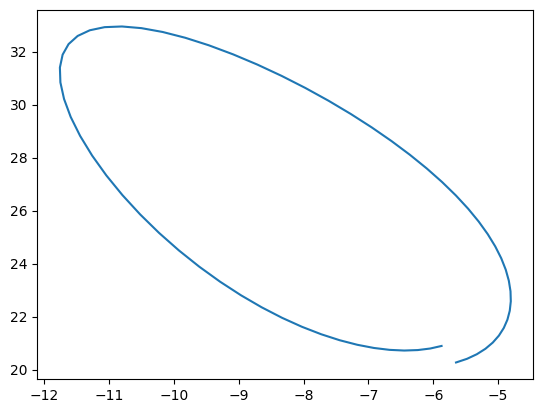

In [9]:
plt.plot(X[t0:t0+peaks[0],0],X[t0:t0+peaks[0],2])
plt.show()

# Jacobian estimation

In [10]:
def get_Jacobian(tseries,point,dim,dt,epsilon,small_weight_threshold=1e-5):
    '''Approximates the Jacobian at point "point" '''
    
    #Points before and after evolution
    X=tseries[:-1,:]
    XNew=tseries[1:,:]
    
    #Distance to the considered point
    dist = np.linalg.norm(X-X[point],axis=1)
    
    #Weight for each point
    weight = np.exp(-dist/epsilon)
    
    #Excluding transverse points
    weight[point-10:point+10]=0

    #Adding row of ones
    z = np.hstack([np.ones(X.shape[0]).reshape(-1,1),X])
    
    #Excluding points with small weight
    sel = weight>small_weight_threshold
    
    #Weighting points and excluding small weights
    zw = np.vstack([z[sel,m]*weight[sel] for m in range(z.shape[1])]).T
    znw = np.vstack([XNew[sel,m]*weight[sel] for m in range(XNew.shape[1])]).T
    
    #Linear regression
    A = np.linalg.pinv(zw).dot(znw)
    
    #Eliminating the constants
    J= (A[1:].T-np.identity(3))/(dt)
    return J

In [11]:
#Point where we estimate Jacobian
t0=1000

#Dimension of the state space
dimension=3

J=get_Jacobian(X,t0,dimension,dt,epsilon);
Jexact=J_explicit(X[t0]);

np.set_printoptions(suppress = True)
print(Jexact)
print(J)

[[-10.          10.           0.        ]
 [  8.13792445  -1.           8.01629133]
 [-11.89365235  -8.01629133  -2.66666667]]
[[ -9.20227553   9.49479559   0.3770187 ]
 [  6.19853547  -0.48084871   7.82772736]
 [-10.34569548  -9.38734969  -2.6504745 ]]
